In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
cmap = cc.cm.blues
import scipy
%matplotlib inline
%config Completer.use_jedi = False
import os
savepath = '../figs/'
try:
    os.chdir('digits_summaries')
except:
    os.chdir('../digits_summaries')

In [14]:
D = np.load('results_headlr_med_pen=cross_rc_thresh_hard.npz')
# D = np.load('results_headlr_med_untrained_L2matched_pen=cross_rc_thresh_hard.npz')
d = D['d']
in_shape = np.array([8,6])    
N = int(d[0]*np.prod(in_shape-2)+d[1]*np.prod((in_shape-4))+d[1]*np.prod((in_shape-4)/2)+d[2])
train_losses=D['train_losses']
test_losses=D['test_losses']  #(task,resp,frac_correct)
sparsities = D['sparsities']
alphas=D['alphas']
cms = D['cms']
l1s=D['l1s']
alignments=D['alignments']
trials=train_losses.shape[0]
print(test_losses.shape) #trials, alpha, lambda, losses


(40, 12, 9, 3)


[9.9999e-01 9.9990e-01 9.9900e-01 9.9000e-01 9.5000e-01 9.0000e-01
 8.5000e-01 7.5000e-01 5.0000e-01 1.0000e-03 1.0000e-04 1.0000e-05]


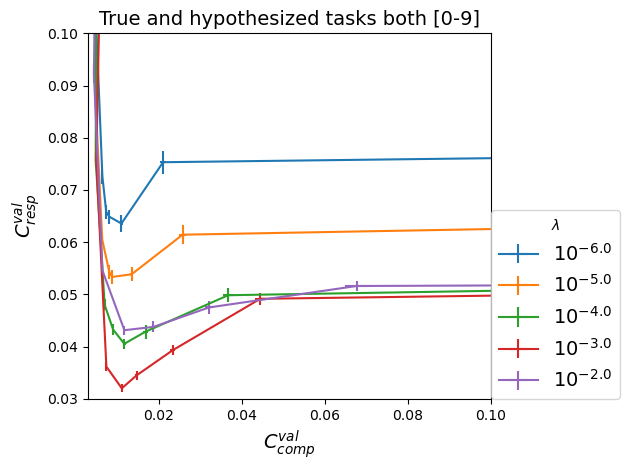

In [91]:

fig,ax = plt.subplots()#(figsize=(10,10))

# order = [0,2,3,4,5,6,1]
alphas=np.array(alphas)
order = np.arange(alphas.size)[:]
print(alphas)
L_task = np.nanmean(test_losses[:,:,:,0],axis=0)[order,:]
L_resp = np.nanmean(test_losses[:,:,:,1],axis=0)[order,:]
e_task = np.nanstd(test_losses[:,:,:,0],axis=0)[order,:]/np.sqrt(trials)
e_resp = np.nanstd(test_losses[:,:,:,1],axis=0)[order,:]/np.sqrt(trials)
# plt.plot(L_task,L_resp)
show_lis = np.arange(0,l1s.size,2)
# show_lis = np.array([4])

for li in show_lis:
    plt.errorbar(L_task[:,li],L_resp[:,li],xerr=e_task[:,li],yerr=e_resp[:,li])
#     plt.plot(L_task[:,li],L_resp[:,li])
plt.legend(['$10^{{{}}}$'.format(i) for i in np.log10(l1s[show_lis])],loc=(1,0),title='$\lambda$',fontsize=14)


plt.xlabel('$C^{val}_{comp}$',fontsize=14)
plt.ylabel('$C^{val}_{resp}$',fontsize=14)
plt.title('True and hypothesized tasks both [0-9]',fontsize=14)
# plt.xlim([0.0015,0.02])
# plt.ylim([0.005,0.025])

# plt.xlim([0.003,0.1])
# plt.ylim([0.03,0.15])

plt.xlim([0.003,0.1])
plt.ylim([0.03,0.1])


fig.tight_layout()

plt.savefig(savepath+'digits_teacher_curves_example')


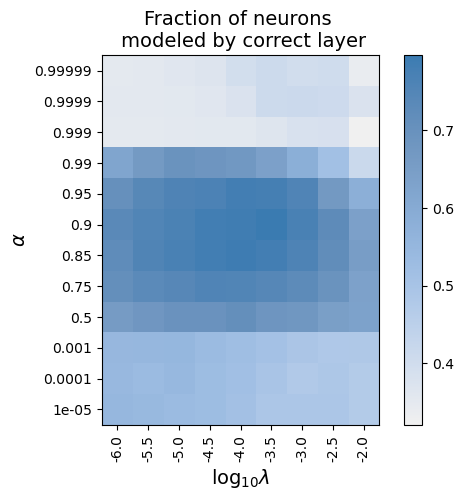

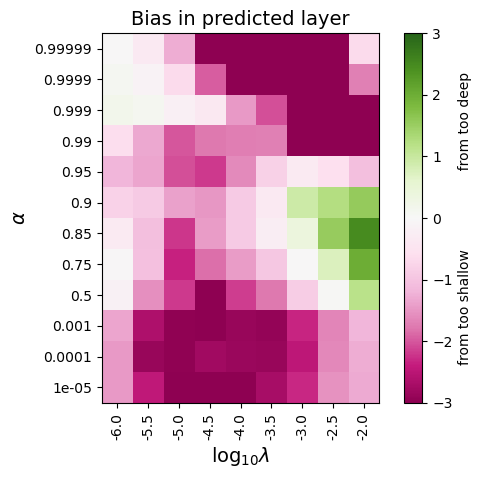

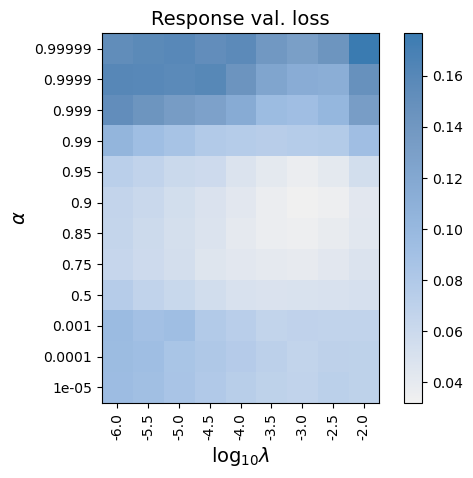

In [152]:
from_too_deep = (cms[:,:,:,0,1]+cms[:,:,:,0,2]+cms[:,:,:,1,2])/np.sum(cms,axis=(-2,-1))
from_too_shallow = (cms[:,:,:,1,0]+cms[:,:,:,2,0]+cms[:,:,:,2,1])/np.sum(cms,axis=(-2,-1))
just_right = (cms[:,:,:,0,0]+cms[:,:,:,1,1]+cms[:,:,:,2,2])/np.sum(cms,axis=(-2,-1))

plt.imshow(np.nanmean(just_right,axis=0),cmap=cmap)
# plt.imshow(np.std(just_right,axis=0))
plt.title('Fraction of neurons \n modeled by correct layer',fontsize=14)
plt.xticks(np.arange(l1s.size),np.round(np.log10(l1s),1),rotation=90)
plt.xlabel('$\\log_{10}\\lambda$',fontsize=14)
plt.yticks(np.arange(alphas.size),alphas)
plt.ylabel('$\\alpha$',fontsize=14)
plt.colorbar()

fig,ax = plt.subplots()
# plt.imshow(np.mean(from_too_deep-from_too_shallow,axis=0),vmin=-0.2,vmax=0.2,cmap='PiYG')
plt.imshow(np.nanmean(from_too_deep-from_too_shallow,axis=0)/np.nanstd(from_too_deep-from_too_shallow,axis=0),vmin=-3,vmax=3,cmap='PiYG')

plt.title('Bias in predicted layer',fontsize=14)
plt.xticks(np.arange(l1s.size),np.round(np.log10(l1s),1),rotation=90)
plt.xlabel('$\\log_{10}\\lambda$',fontsize=14)
plt.yticks(np.arange(alphas.size),alphas)
plt.ylabel('$\\alpha$',fontsize=14)
plt.colorbar(label='from too shallow                  from too deep')



fig,ax = plt.subplots()
plt.imshow(np.nanmean(test_losses[:,:,:,1],axis=0),cmap=cmap)

plt.title('Response val. loss',fontsize=14)
plt.xticks(np.arange(l1s.size),np.round(np.log10(l1s),1),rotation=90)
plt.xlabel('$\\log_{10}\\lambda$',fontsize=14)
plt.yticks(np.arange(alphas.size),alphas)
plt.ylabel('$\\alpha$',fontsize=14)
plt.colorbar()


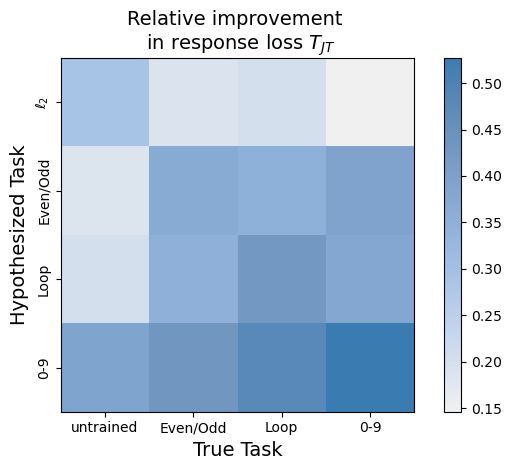

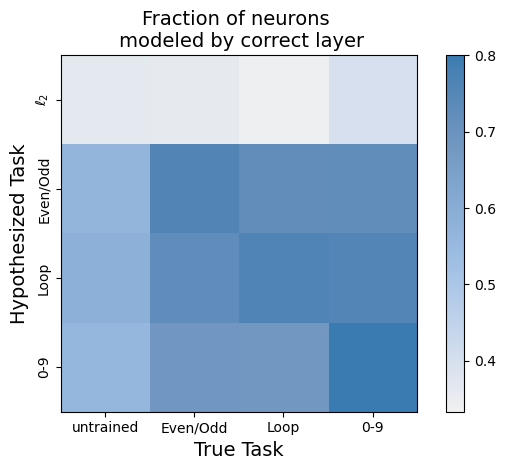

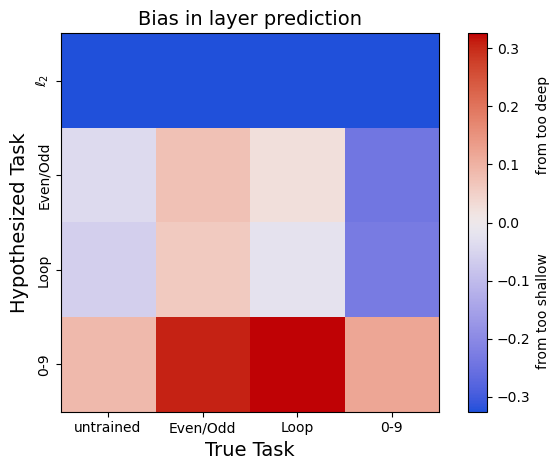

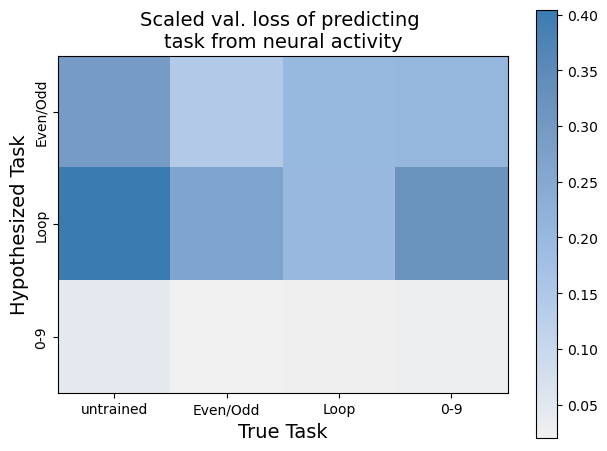

In [63]:
order = [0,1,2,3]
trials = 40
task_dims = [2,2,10]


matchstrs = [['_L2matched','_eomatched','_loopmatched',''][i] for i in order]
trainstrs = [['_untrained', '_eotrained','_looptrained',''][i] for i in order]
hypo_labels = [['$\ell_2$','Even/Odd','Loop','0-9'][i] for i in order]
train_labels = [['untrained','Even/Odd','Loop','0-9'][i] for i in order]


layer_acc = np.zeros((len(matchstrs),len(trainstrs)))
layer_bias = np.zeros((len(matchstrs),len(trainstrs)))
teaches = np.zeros((trials,len(matchstrs),len(trainstrs)))
SdP = 6*8/1024
d = [16,32,128,10]
shapes = np.array([[d[0]*24, d[1]*10,d[2]]])
rs = 1/np.sqrt(shapes.T.dot(shapes))
# rs = np.tile(np.sqrt(shapes),[3,1])
# rs = rs/rs.T

all_Ls = np.nan*np.ones((trials,len(matchstrs),len(trainstrs),20,20))
all_fracs = np.nan*np.ones((trials,len(matchstrs),len(trainstrs),20,20))
all_biass = np.nan*np.ones((trials,len(matchstrs),len(trainstrs),20,20))

task_matches = np.zeros((trials,len(matchstrs)-1,len(trainstrs)))

for m_i, match in enumerate(matchstrs):
    for t_i, train in enumerate(trainstrs):
        fname = 'results_headlr_med'+train+match+'_pen=cross_rc_thresh_hard.npz'

        D = np.load(fname)
        alpha_min, lambda_min = np.unravel_index(np.argmin(np.mean(D['test_losses'][:,:,:,1],axis=0)),(D['alphas'].size,D['l1s'].size))
#         alpha_min = 0
        
        bls = np.mean(D['test_losses'][:,-1,lambda_min,1])
        if m_i>0:
            a = D['task_alignments'][:,alpha_min,lambda_min,1,m_i-1,:]
            task_matches[:,m_i-1,t_i] = np.min(a[np.isfinite(a)],axis=-1)/(task_dims[m_i-1])

        teaches[:,m_i,t_i] = (bls-D['test_losses'][:,alpha_min,lambda_min,1])/bls 

        cms = D['cms']
        cms*= np.reshape(rs,(1,1,1,3,3)) #change normalization of W_ij
#         print(np.sum(cms,axis=(-2,-1)))
        bias_denom = np.sum(cms,axis=(-2,-1))-(cms[:,:,:,0,0]+cms[:,:,:,1,1]+cms[:,:,:,2,2])
        from_too_deep = (cms[:,:,:,0,1]+cms[:,:,:,0,2]+cms[:,:,:,1,2])/bias_denom
        from_too_shallow = (cms[:,:,:,1,0]+cms[:,:,:,2,0]+cms[:,:,:,2,1])/bias_denom
        just_right = (cms[:,:,:,0,0]+cms[:,:,:,1,1]+cms[:,:,:,2,2])/np.sum(cms,axis=(-2,-1))
        layer_acc[m_i,t_i] = np.mean(just_right,axis=0)[alpha_min,lambda_min]
        lbs = (from_too_deep-from_too_shallow)#/(np.std(from_too_deep-from_too_shallow,axis=0)/np.sqrt(trials))
        layer_bias[m_i,t_i] = np.mean(lbs,axis=0)[alpha_min,lambda_min]
        
        all_biass[:,m_i,t_i,:D['alphas'].size,:D['l1s'].size] = lbs
        all_fracs[:,m_i,t_i,:D['alphas'].size,:D['l1s'].size] = just_right
        all_Ls[:,m_i,t_i,:D['alphas'].size,:D['l1s'].size] = (bls-D['test_losses'][:,:,:,1])/bls

fnames = ['Tjt','frac_correct','bias','zfromy_loss']
titles = ['Relative improvement \n in response loss $T_{JT}$','Fraction of neurons \n modeled by correct layer','Bias in layer prediction','Scaled val. loss of predicting \ntask from neural activity']
data = [np.mean(teaches,axis=0),layer_acc,layer_bias,np.mean(-task_matches,axis=0)/np.sqrt(np.expand_dims(task_dims,-1))]

cmaps = [cmap,cmap,cc.cm.coolwarm,cmap]
vmins = [None,1/3,'sym',None]
vmaxs = [None,0.8,'sym',None]
 
for i in range(len(titles)):
    fig,ax = plt.subplots()
    vmin = vmins[i] if vmins[i]!='sym' else -np.max(data[i])
    vmax = vmaxs[i] if vmaxs[i]!='sym' else np.max(data[i])
    
    plt.imshow(data[i],cmap=cmaps[i],vmin=vmin,vmax=vmax)
    plt.colorbar(label='from too shallow                  from too deep' if i==2 else None)
    plt.title(titles[i],fontsize=14)
    plt.yticks(np.arange(len(hypo_labels)-(i==3)),hypo_labels[int(i==3):],rotation=90,verticalalignment='center')
    plt.ylabel('Hypothesized Task',fontsize=14)
    plt.xticks(np.arange(len(train_labels)),train_labels)
    plt.xlabel('True Task',fontsize=14)
    fig.tight_layout()
    plt.savefig(savepath+'digits_'+fnames[i])

                




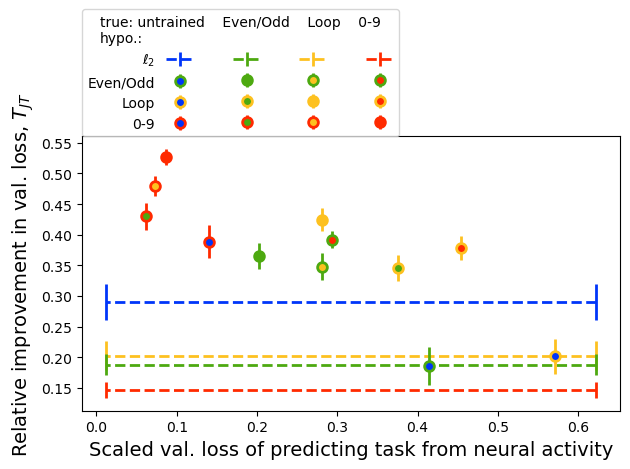

In [52]:
fig,ax = plt.subplots()
cmap2 = cc.cm.rainbow
cs = cmap2(np.arange(4)/3)
_, matchs, trains = task_matches.shape


hs = np.empty((trains, matchs+1),dtype=object)

for t_i in range(trains):
    h = plt.errorbar([-np.min(task_matches)+0.05,-np.max(task_matches)-0.05],[np.mean(teaches,axis=0)[0,t_i]]*2,yerr=np.std(teaches[:,0,t_i])/np.sqrt(trials),ls='--',lw=2,c=cs[t_i],zorder=-t_i)
    hs[t_i,0] = h

for t_i in range(trains):
    for m_i in range(matchs):   
        h = plt.errorbar(-np.mean(task_matches[:,m_i,t_i]),np.mean(teaches[:,m_i+1,t_i]),yerr=np.std(teaches[:,m_i+1,t_i])/np.sqrt(trials),fmt='o'
                         ,markerfacecolor=cs[t_i],ecolor=cs[m_i+1],markeredgecolor=cs[m_i+1],markeredgewidth=2,elinewidth=2,ms=7)
        hs[t_i,m_i+1] = h

matchs+=1
labels = hypo_labels[-matchs:]+['']*(matchs-1)*(trains+1)
title = 'true:'+' '*1+(' '*4).join(train_labels[-trains:])+'\nhypo.:'
plt.legend(np.ravel(hs),labels,ncol=trains,markerfirst=False,title=title,loc=(0,1))

plt.xlabel('Scaled val. loss of predicting task from neural activity',fontsize=14)
plt.ylabel('Relative improvement in val. loss, $T_{JT}$',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'digits_Tjt_vs_zfromy_loss')


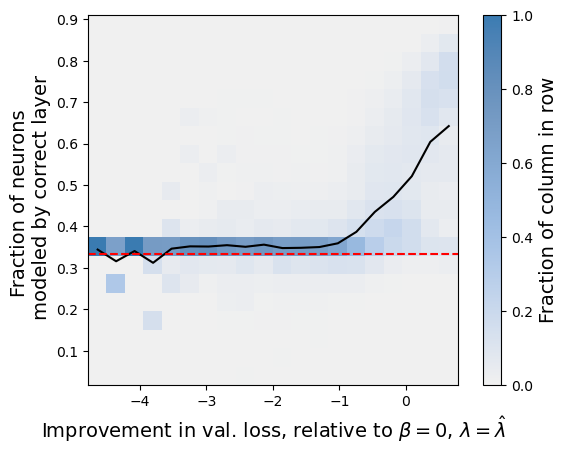

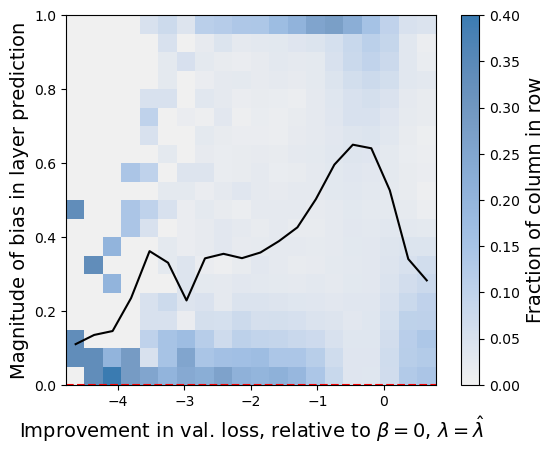

In [64]:
ys = [all_fracs, np.abs(all_biass)]
ylabels = ['Fraction of neurons \n modeled by correct layer','Magnitude of bias in layer prediction']
fnames = ['frac_correct','bias']

for i in range(2):
    x = all_Ls
    y = ys[i]
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    fig,ax = plt.subplots()
    bins=20
    M,xe,ye = np.histogram2d(x,y,bins=bins)
    M=M.T
    my = np.zeros(bins)
    for b in range(bins):
        my[b] = np.mean(y[(xe[b]<x) & (x<xe[b+1])])
    xcs = (xe[:-1]+xe[1:])/2
    plt.imshow(M/np.sum(M,axis=0,keepdims=True),cmap=cmap,origin='lower',extent=[xe[0],xe[-1],ye[0],ye[-1]],aspect=(xe[0]-xe[-1])/(ye[0]-ye[-1]))
    plt.plot(xcs,my,'k')
    plt.plot([xe[0],xe[-1]],[1/3 if i==0 else 0]*2,'r--')
    
    plt.plot()
    plt.ylabel(ylabels[i],fontsize=14)
    plt.xlabel(r'Improvement in val. loss, relative to $\beta=0$, $\lambda=\hat\lambda$',fontsize=14)
    clb = plt.colorbar()
    clb.set_label('Fraction of column in row',fontsize=14)
    plt.savefig(savepath+'digits_'+fnames[i]+'_vs_ri')


In [54]:
print(rs)

[[0.00260417 0.00285272 0.00451055]
 [0.00285272 0.003125   0.00494106]
 [0.00451055 0.00494106 0.0078125 ]]


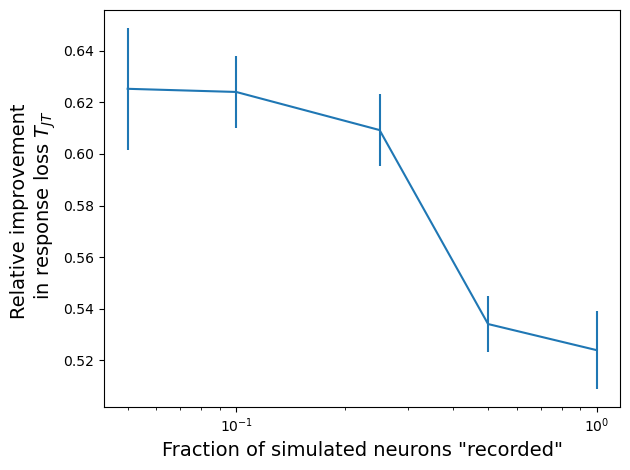

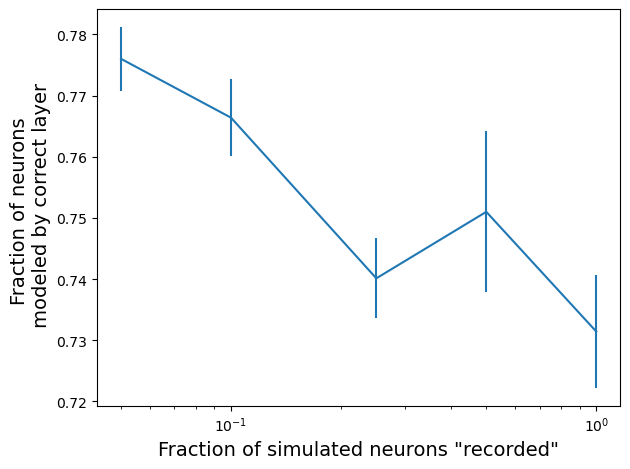

In [55]:

D = np.load('results_headlr_med_pen=cross_rc_thresh_hard_subsets.npz')
d = D['d']
in_shape = np.array([8,6])    
N = int(d[0]*np.prod(in_shape-2)+d[1]*np.prod((in_shape-4))+d[1]*np.prod((in_shape-4)/2)+d[2])
train_losses=D['train_losses']
test_losses=D['test_losses']
sparsities=D['cpfns']
cms = D['cms']
d = [16,32,128,10]
shapes = [d[0]*24, d[1]*10,d[2]]
rs = np.tile(np.sqrt(shapes),3)
cms*= np.reshape(rs/rs.T,(1,1,1,3,3))
alignments=D['alignments']
alphas=D['alphas']
subsets = D['subsets']
l1s=D['l1s']

trials=train_losses.shape[0]

rlm = np.mean(test_losses[:,:,:,:,1],axis=0)
rlsem = np.std(test_losses[:,:,:,:,1],axis=0)/np.sqrt(trials)
baseline = np.min(rlm[-3:-1,:,:],axis=(0,1))
best = np.min(rlm,axis=(0,1))
teacherness = (baseline-best)/baseline

fig,ax = plt.subplots()
plt.errorbar(subsets,teacherness,yerr=rlsem[rlm==best]/baseline)
plt.xscale('log')
plt.xlabel('Fraction of simulated neurons \"recorded\"',fontsize=14)
plt.ylabel('Relative improvement \n in response loss $T_{JT}$',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'digits_TJT_vs_subsamp')

fig,ax = plt.subplots()
just_right = (cms[:,:,:,:,0,0]+cms[:,:,:,:,1,1]+cms[:,:,:,:,2,2])/np.sum(cms,axis=(-2,-1))
inds = rlm==np.min(rlm,axis=(0,1),keepdims=True)
sems = np.std(just_right,axis=0)[inds]/np.sqrt(trials)
just_right = np.mean(just_right,axis=0)[inds]
plt.errorbar(subsets,just_right,yerr=sems)
plt.xscale('log')
plt.xlabel('Fraction of simulated neurons \"recorded\"',fontsize=14)
plt.ylabel('Fraction of neurons \n modeled by correct layer',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'digits_layeracc_vs_subsamp')


Theory

In [93]:
os.chdir('../2LL_summaries')

[[1.31474681e-04 1.31474681e-04 1.31474681e-04]
 [1.39267563e-04 5.45692919e-05 5.45692919e-05]
 [1.61483984e-04 1.09100101e-04 2.26263820e-05]]
[[0.01056609 0.01056609 0.01056609]
 [0.01068608 0.01675785 0.01675785]
 [0.01259494 0.01198237 0.01832834]] (3, 3, 30)
[[2.46504781e-04 2.46504781e-04 2.46504781e-04]
 [2.35179965e-04 1.41860912e-04 1.41860912e-04]
 [1.82737998e-04 1.06158200e-04 9.55385353e-05]]
[[0.01008708 0.01008708 0.01008708]
 [0.00568304 0.01953326 0.01953326]
 [0.00810713 0.0081175  0.02623268]] (3, 3, 30)


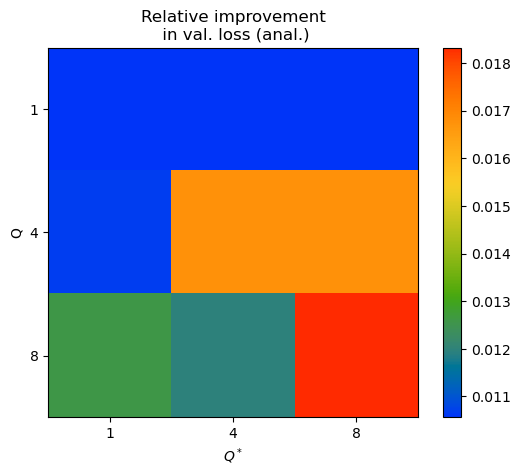

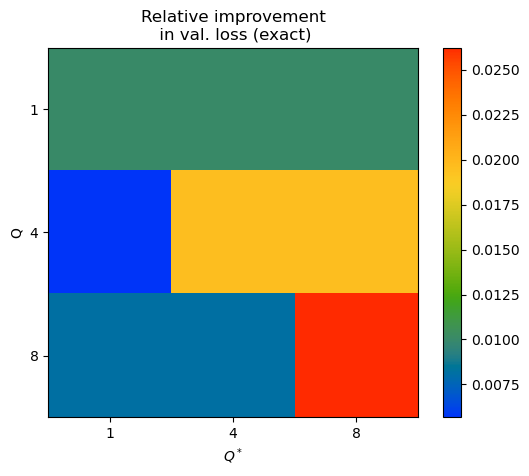

In [9]:
Ns = [5,10]
Qs = [1,4,8]
npars = 30
N=10

approxs = [('(anal.)','Eanals'),('(exact)','Enums')]
tt = False
for paren, key in approxs:
    Tys = np.zeros((len(Qs),len(Qs),npars))
    for qt,Qt in enumerate(Qs):
        for q,Q in enumerate(Qs):
            D = np.load('run_A=BWp_P=50_S=30_N='+str(N)+'_Q='+str(Q)+'_Qt='+str(min(Qt,Q))+'.npz',allow_pickle=True)
            L_y = D[key]
            if tt:
                T = (L_y[:,0]-L_y[:,-1])/L_y[:,0] #task-training method
            elif key == 'Enums':
                T = (L_y[:,0]-np.min(L_y,axis=1))/L_y[:,0] #our method
            else:
                T = D['Ty'] #our method, all approximations
            Tys[q,qt,:] = T

    fig,ax = plt.subplots()
    plt.imshow(np.mean(Tys,axis=-1),cmap=cmap)
    plt.yticks(np.arange(len(Qs)),Qs)
    plt.ylabel('Q')
    plt.xticks(np.arange(len(Qs)),Qs)
    plt.xlabel('$Q^*$')
    plt.colorbar()
    plt.title('Relative improvement\n in val. loss '+paren)

    print(np.std(Tys,axis=-1)/np.sqrt(npars))
    print(np.mean(Tys,axis=-1), Tys.shape)

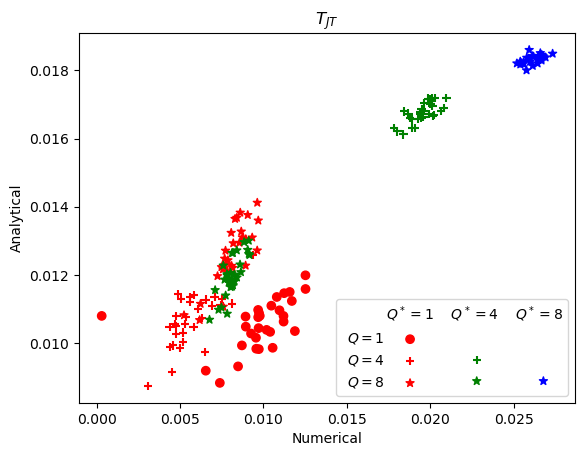

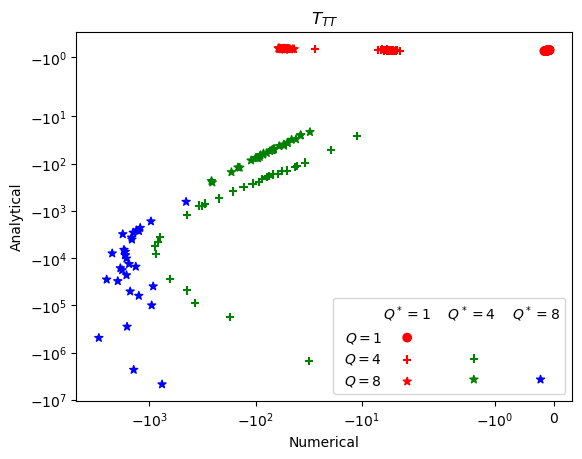

In [101]:
fig,ax=plt.subplots()
fig2,ax2=plt.subplots()

hs = np.empty((3,3),dtype=object)
cs = ['r','g','b']
ms = ['o','+','*']

Qs = [1,4,8]
for Qi,Q in enumerate(Qs):
    for Qti, Qt in enumerate(Qs):
        if Qt>Q:
            h = plt.scatter([],[],s=0)
            hs[Qti][Qi] = h
            continue
        D = np.load('run_A=BWp_P=50_S=30_N=10_Q='+str(Q)+'_Qt='+str(Qt)+'.npz',allow_pickle=True)
        allEa = D['Eanals']
        allEn = D['Enums']
        allEf = D['Efuns']
        allsea = D['seanals']
        allsen = D['senums']
        Tymin_approx = D['Ty']
        try:
            Ttt_approx = D['Ttt_approx'] #np.zeros_like(Tymin_approx)#
        except:
            print(Q,Qt)
            stop
        by_approx = D['by']
        pars = D['pars']
        Bs = D['Bz']
        Wy = pars[-1]
        bs = pars[-3]
        its=pars[-2]

        Tn = (allEn[:,0]-np.min(allEn,axis=1))/allEn[:,0]
        Ttt_n = (allEn[:,0]-allEn[:,-1])/allEn[:,0]
        bmin_n = np.argmin(allEn,axis=1)
        which = (bmin_n<bs.size-1)&(bmin_n>0)&(by_approx<bs[-1])&(by_approx>bs[0])        
        plt.figure(fig)
#         h = plt.scatter(Tn[which],Tymin_approx[which],c=[cs[Qti]]*np.sum(which),s=[2*Q]*np.sum(which),cmap=cmap)
        h = plt.scatter(Tn[which],Tymin_approx[which],c=[cs[Qti]]*np.sum(which),marker=ms[Qi])
        hs[Qti][Qi] = h
        plt.figure(fig2)

        plt.scatter(Ttt_n[which],Ttt_approx[which],c=[cs[Qti]]*np.sum(which),marker=ms[Qi])
        plt.xscale('symlog')
        plt.yscale('symlog')
        
labels = ['$Q=$'+str(Q) for Q in Qs]+['']*(len(Qs)-1)*len(Qs)
title = ' '*10+(' '*4).join(['$Q^*=$'+str(Q) for Q in Qs])

for i in range(2):
    plt.figure([fig,fig2][i])
    plt.title(['$T_{JT}$','$T_{TT}$'][i])
    plt.legend(np.ravel(hs),labels,ncol=3,markerfirst=False,title=title,loc='lower right')
    plt.xlabel('Numerical')
    plt.ylabel('Analytical')
    plt.savefig(savepath+'/2ll_num_vs_anal_'+['tjt','ttt'][i])
    

In [63]:
Qs = [1,4,8]
[(q,q_true) for q in Qs for q_true in Qs if q_true<=q]

[(1, 1), (4, 1), (4, 4), (8, 1), (8, 4), (8, 8)]

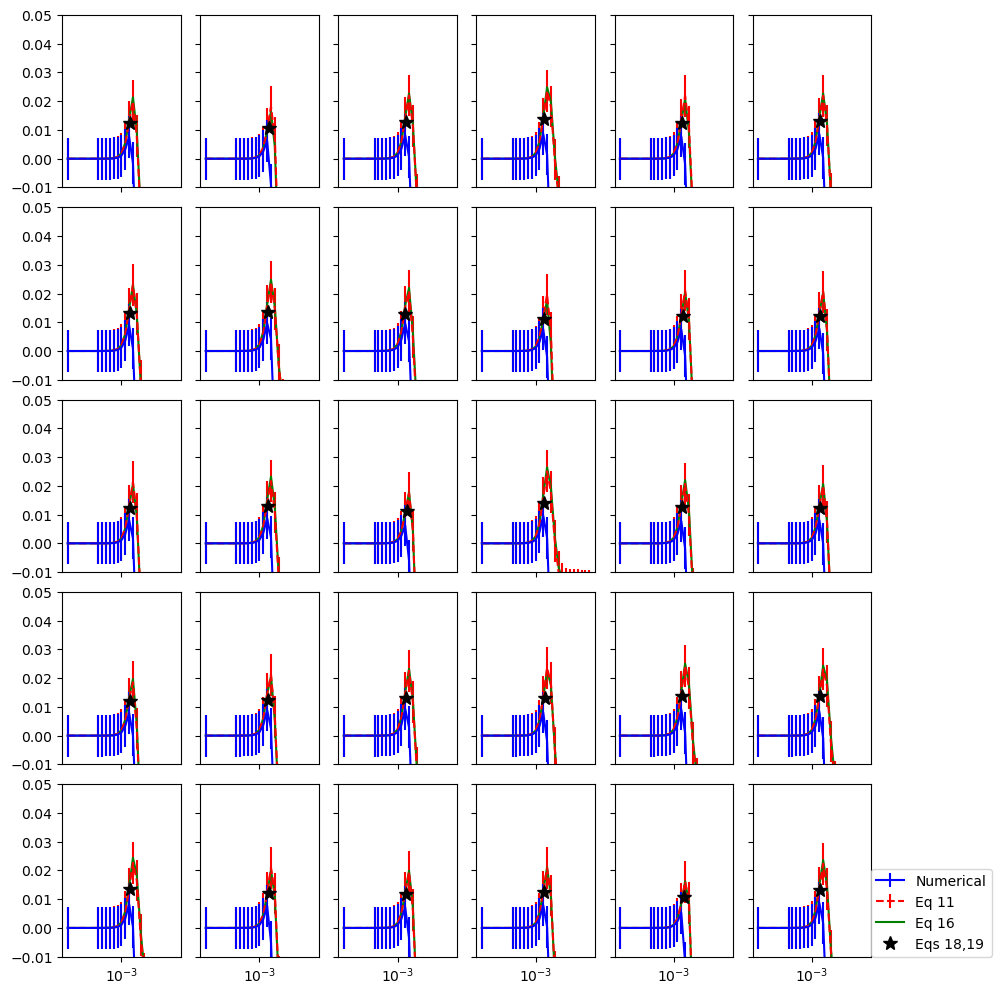

In [92]:
Q=8
Qt=1

D = np.load('run_A=BWp_P=50_S=30_N=10_Q='+str(Q)+'_Qt='+str(Qt)+'.npz',allow_pickle=True)
allEa = D['Eanals']
allEn = D['Enums']
allEf = D['Efuns']
allsea = D['seanals']
allsen = D['senums']
Tymin_approx = D['Ty']
by_approx = D['by']
pars = D['pars']
Bs = D['Bz']
Wy = pars[-1]
bs = pars[-3]
its=pars[-2]

npars=30
fig,ax = plt.subplots(5,6,sharex=True,sharey=True,figsize=(10,10))
for i in range(npars):
    h3=ax[i//6,i%6].errorbar(bs+1e-10,(allEf[i,0]-allEf[i,:])/allEf[i,0],fmt='g')
    h2=ax[i//6,i%6].errorbar(bs*1+1e-10,(allEa[i,0]-allEa[i,:])/allEa[i,0],yerr=allsen[i,0]/allEa[i,0]/np.sqrt(its),fmt='r--')
    h1=ax[i//6,i%6].errorbar(bs+1e-10,(allEn[i,0]-allEn[i,:])/allEn[i,0],yerr=allsea[i,0]/allEn[i,0]/np.sqrt(its),fmt='b')   
    h4=ax[i//6,i%6].errorbar(by_approx[i],Tymin_approx[i],fmt='k*',markersize=10)

plt.xscale('log')
plt.ylim([-0.01,0.05])
# plt.ylim([-20,0.025])
plt.legend([h1,h2,h3,h4],['Numerical','Eq 11','Eq 16','Eqs 18,19'],loc=(1,0))
# plt.xlim([1e-10,1e-3])
fig.tight_layout()